# Modeling and Electromagnetic simulation
 Modeling and Electromagnetic simulation

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

import meent

In [2]:
pol = 0  # 0: TE, 1: TM

n_I = 1  # n_superstrate
n_II = 1  # n_substrate

theta = 20 * np.pi / 180
phi = 50 * np.pi / 180

wavelength = 900

thickness = [500]
period = [1000]

fourier_order = [30]

type_complex = np.complex128

grating_type = 0

## 1.1 Modeling

### ucell (unit cell)

ucell (unit cell) is a 3-dimensional array which has refractive index elements. It supports complex index, 2-dimensional grating and multi-layered structures.

The order of dimensions: Z Y X.


        ______________________
       |\                     \
       | \                     \  Y
       |  \                     \
       |\  \_____________________\
       | \ |      Layer 1        |
       \  \|_____________________|
        \  |                     | Z
         \ |      Layer 2        |
          \|_____________________|
                     X

* Z: Stack of the layers (1st axis of ucell)
   * In z-direction, layers (2D arrays) are stacked from top to bottom.
   * For example, ucell[0] is Layer 1 in the figure (2D array on the top) and ucell[1] is the next layer below.
* Y: Depth of the structure (2nd axis of ucell)
    * 2 dimensional grating is implemented on this and the last axes.
    * For 1 dimensional case, this is not used and fixed to 1.

* X: Width of the structure (3rd axis of ucell)
    * This is the default axis. 1 dimensional grating is implemented on this axis.



#### ucell examples

In [3]:
ucell_1d_s = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

1D grating, single layer

In [4]:
ucell_1d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ],
    ],
    [
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

1D grating, multi layer

In [5]:
ucell_2d_s = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

2D grating, single layer

In [6]:
ucell_2d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 0, 1, 1, 0, 1, 0, 2, 1, ],
        [0, 1, 1, 1, 2, 4, 1, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 2, 0, 1, 2, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, ],
        [0, 1, 3, 1, 1, 1, 1, 1, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

2D grating, multi layer

### Wave

#### $\theta$: angle of incidence


          Incidence   normal
               \\      |
                \\     |
                 \\ 𝜃 (angle of incidence)     
                  \\   |
                   \\  |             
                    \\ |
                     \\|                       Z-axis
     ____________________________________        |
    |              Layer 1               |       |
    |____________________________________|       |_____ X-axis

#### $\phi$: azimuthal (rotation) angle

    



            plane of incidence
              |     \
              |      \
              |       \
              |        \
              |         \
              |          \
              |           \
               \           \
           /    \           \                 /
          /      \           \               / 
         / -------\---------- \             /              
        /          \ 𝜙 (rotation angle)    /  /          Z-axis  
       /            \          |          /  /            |
      /______________\_________|_________/  / /           |
      |   Layer 1     \        |         | / /            |_____ X-axis
      |________________\_______|_________|/ /            /
      |   Layer 2       \      |         | /            /
      |__________________\_____|_________|/           Y-axis
                          \    |                     
                   



  In 2D (projection on XY-plane),
  
     |
     |
     |--------------- X-axis
     |\\ 𝜙 (rotation angle)
     | \\
     |  \\
     |   \\
     |    \\
     |     \\
     Y     Incidence
    axis
    

## 1.2 EM Simulation

In [7]:
mee = meent.call_mee(backend=0, grating_type=grating_type, pol=pol, n_I=n_I, n_II=n_II, theta=theta, phi=phi, fourier_order=fourier_order, wavelength=wavelength, period=period, ucell=ucell_1d_s, thickness=thickness, type_complex=type_complex, fft_type=0, improve_dft=True)

call meent operator by `meent.call_mee`.
Here, backend can be selected with keyword `backend`

```python
backend = 0  # Numpy backend
backend = 1  # JAX backend
backend = 2  # PyTorch backend
```


### Diffraction Efficiency

#### Diffraction


      Incidence      Backward Diffraction 
                         (Reflected)
         ||               
         ||          -1th    0th    +1th
         ||          order  order   order
         ||             \     |     /
         ||          ... \    |    / ...
         ||               \   |   /   
         ||                \  |  /    n_I:refractive index of superstrate
     ____________________________________
    |              Layer 1               |
    |____________________________________|
                       .                        z-axis 
                       .                           |
                       .                           |
     ____________________________________          |_____ x-axis 
    |              Layer N               |
    |____________________________________|
                                     n_II:refractive index of substrate
                           /  |  \    
                          /   |   \
                    ...  /    |    \  ...
                        /     |     \
               -2nd   -1th   0th    +1th   +2th
              order  order  order  order  order
              
                     Forward Diffraction 
                        (Transmitted)   

In [8]:
t0 = time.time()
de_ri, de_ti = mee.conv_solve()
print(f'time: ', time.time() - t0)

time:  0.2368483543395996


In [9]:
center = de_ri.shape[0] // 2

print('Diffraction Efficiency of Reflection:', np.round(de_ri[center-1:center+2], 3))
print('Diffraction Efficiency of Transmission:', np.round(de_ti[center-1:center+2], 3))

Diffraction Efficiency of Reflection: [0.    0.803 0.   ]
Diffraction Efficiency of Transmission: [0.    0.197 0.   ]


### Field Distribution

In [10]:
t0 = time.time()
field_cell = mee.calculate_field(res_z=100, res_y=1, res_x=100)
print(f'time: ', time.time() - t0)

time:  0.024094820022583008


#### ZX direction (Side View)

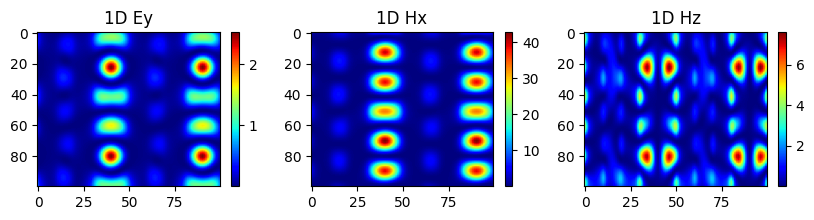

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10,2))
if pol == 0:  # TE
    title = ['1D Ey', '1D Hx', '1D Hz', ]
else:  # TM
    title = ['1D Hy', '1D Ex', '1D Ez', ]

for ix in range(len(title)):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

#### YZ Direction (Top View)

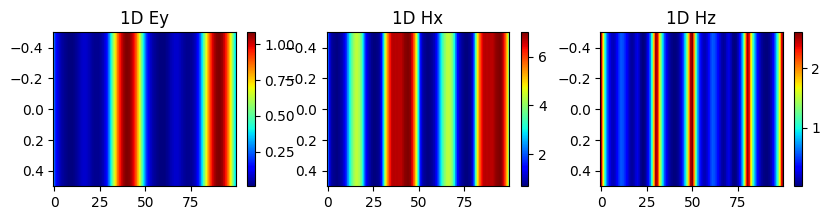

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10,2))
if pol == 0:  # TE
    title = ['1D Ey', '1D Hx', '1D Hz', ]
else:  # TM
    title = ['1D Hy', '1D Ex', '1D Ez', ]

for ix in range(len(title)):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

## 1.3 Example: multilayer 2D

In [13]:
grating_type = 2
fourier_order = [10, 9]
thickness = [100, 200, 400, 245]
period = [1000, 2000]

ucell_2d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 0, 1, 1, 0, 1, 0, 2, 1, ],
        [0, 1, 1, 1, 2, 4, 1, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 2, 0, 1, 2, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, ],
        [0, 1, 3, 1, 1, 1, 1, 1, 1, 1, ],
    ],
]) * 4 + 1  # refractive index


In [14]:
mee = meent.call_mee(backend=0, grating_type=grating_type, pol=pol, n_I=n_I, n_II=n_II, theta=theta, phi=phi, fourier_order=fourier_order, wavelength=wavelength, period=period, ucell=ucell_2d_m, thickness=thickness, type_complex=type_complex, fft_type=0, improve_dft=True)

In [15]:
t0 = time.time()
de_ri, de_ti = mee.conv_solve()
print(f'time: ', time.time() - t0)

time:  10.467445135116577


In [16]:
center = de_ri.shape[0] // 2

print('Diffraction Efficiency of Reflection:\n', np.round(de_ri[center-1:center+2, center-1:center+2], 3))
print('Diffraction Efficiency of Transmission:\n', np.round(de_ti[center-1:center+2, center-1:center+2], 3))

Diffraction Efficiency of Reflection:
 [[0.066 0.016 0.   ]
 [0.453 0.04  0.   ]
 [0.    0.    0.   ]]
Diffraction Efficiency of Transmission:
 [[0.055 0.002 0.   ]
 [0.005 0.008 0.   ]
 [0.    0.    0.   ]]


In [17]:
t0 = time.time()
field_cell = mee.calculate_field(res_z=40, res_y=40, res_x=40)
print(f'time: ', time.time() - t0)

time:  5.318186044692993


#### ZX direction (Side View)

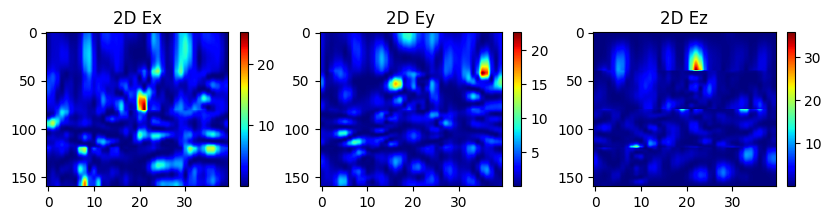

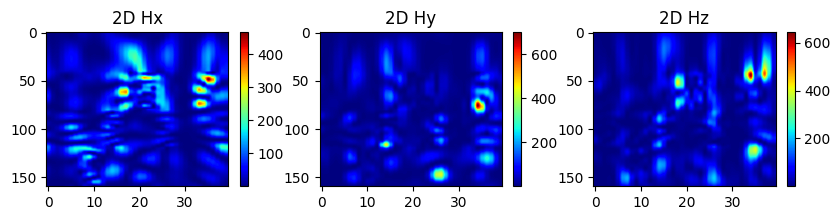

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2))
title = ['2D Ex', '2D Ey', '2D Ez', '2D Hx', '2D Hy', '2D Hz', ]

for ix in range(3):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(10, 2))
for ix in range(3, 6, 1):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix-3].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix-3], shrink=1)
    axes[ix-3].title.set_text(title[ix])

plt.show()

#### YZ Direction (Top View)

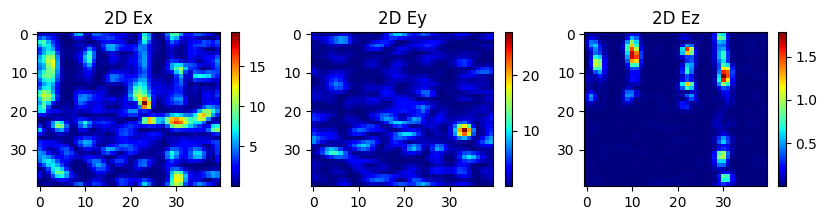

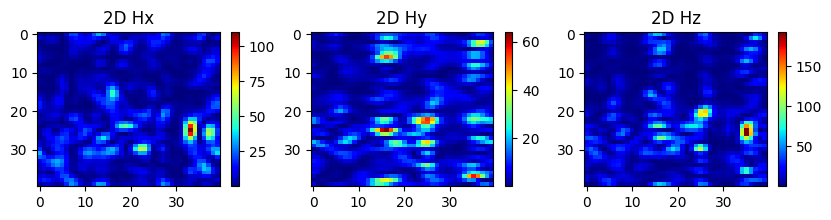

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2))
title = ['2D Ex', '2D Ey', '2D Ez', '2D Hx', '2D Hy', '2D Hz', ]

for ix in range(3):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(10, 2))
for ix in range(3, 6, 1):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix-3].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix-3], shrink=1)
    axes[ix-3].title.set_text(title[ix])

plt.show()